# RM for OBC data redatuming

In [1]:
# env: UD_RM
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve, filtfilt
from scipy.interpolate import interp2d
from scipy.sparse.linalg import lsqr
from scipy.sparse import vstack

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import directwave
from pylops.optimization.leastsquares  import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff

## Inputs

In [2]:
inputfile = '/home/wangn0e/2022-2023/first_research/dataset/overthrust_RM15_pzsum.npz' 
inputdata = np.load(inputfile)
inputdata.files

['Pd', 'Puw', 'r', 's', 'rho', 'vel', 't', 'x', 'z', 'wav']

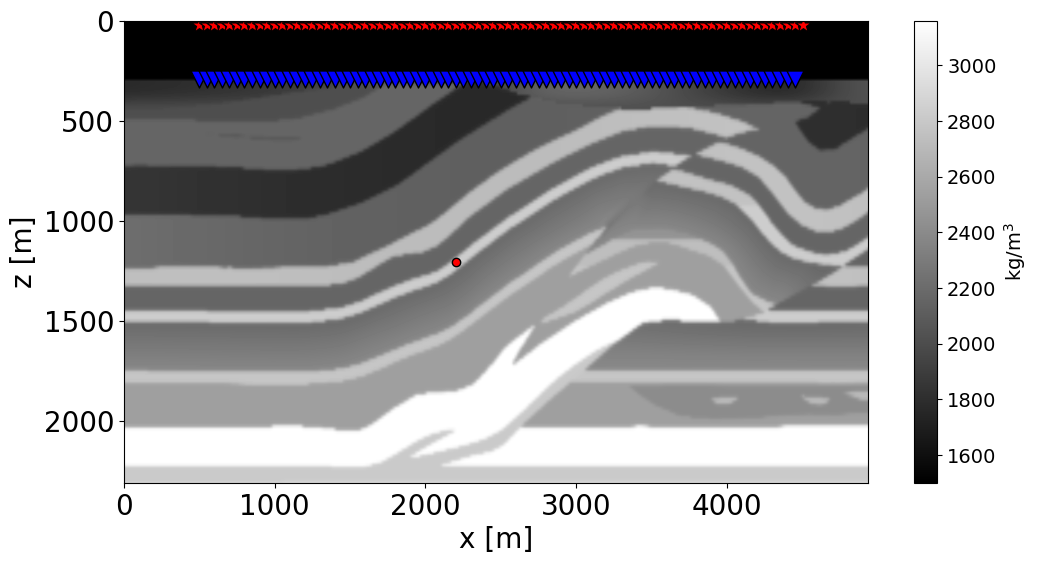

In [4]:
# Receivers
r = inputdata['r']
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# models
rho = inputdata['rho']
vel = inputdata['vel']

# Time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)

# Axes
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav = inputdata['wav']
wav = wav / np.max(np.abs(np.fft.fft(wav))*dt) 
wav_c = np.argmax(wav)

vs=(2200,1206)        #visual source

plt.figure(figsize=(12,6))
h=plt.imshow(vel, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 0::5], s[1, 0::5], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, 0::5],  r[1, 0::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]',fontsize=20),plt.ylabel('z [m]',fontsize=20)
# plt.title('Model and Geometry',fontsize=20)
plt.xticks(fontsize=20),plt.yticks(fontsize=20)
h1 = plt.colorbar(h)
h1.set_label('kg/m$^3$',fontsize=14)
h1.ax.tick_params(labelsize=14)
plt.xlim(x[0], x[-1]);

In [5]:
# velocity data
Pd  = inputdata['Pd'].transpose(1, 0, 2)        # organized as  (s, r, t)->(r, s, t)
Pu  = inputdata['Puw'].transpose(1, 0, 2)       # organized as  (s, r, t)->(r, s, t)

In [6]:
ntaper = 11        # source/receiver taper lenght

# tapering
taper = taper3d(nt, [nr, ns], [ntaper, ntaper], tapertype='hanning') # cosine/hanning
Pd = Pd*taper
Pu = Pu*taper

In [7]:
# Convolve data with wavelet 
convolvedata = False        # Apply convolution to data
if convolvedata:
    Pu = dt * np.apply_along_axis(convolve, -1, Pu, wav, mode='full')
    Pu = Pu[..., wav_c:][..., :nt]
    Pd = dt * np.apply_along_axis(convolve, -1, Pd, wav, mode='full')
    Pd = Pd[..., wav_c:][..., :nt] 

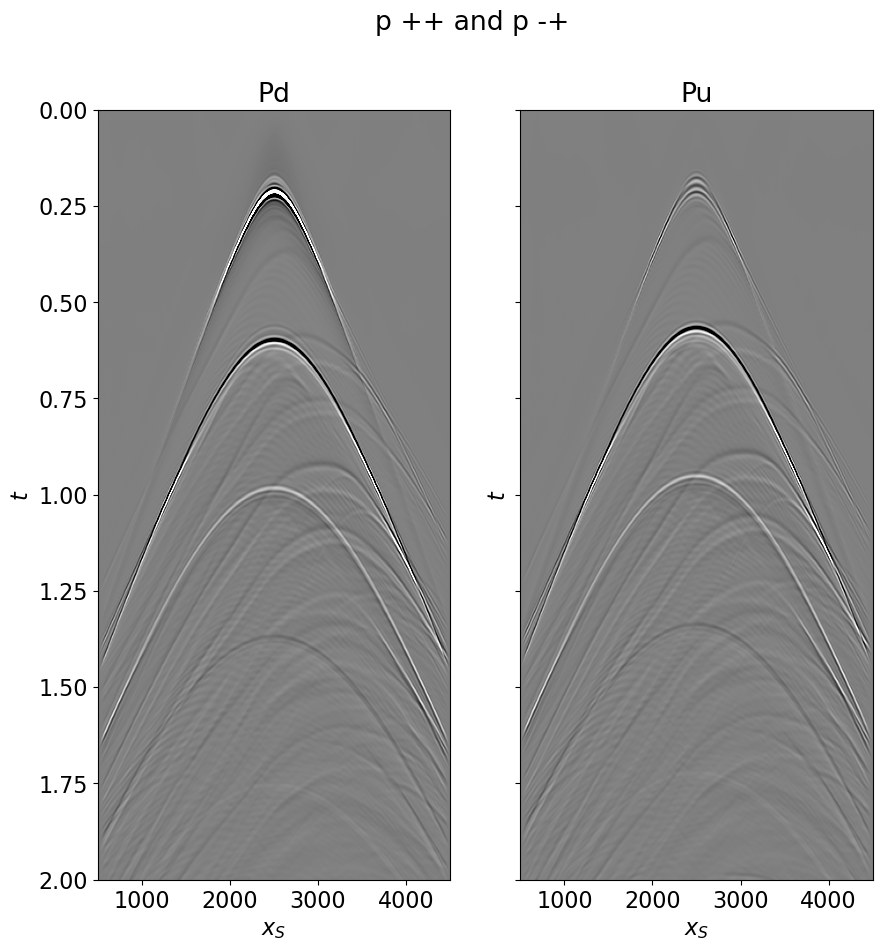

In [8]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 10))
fig.suptitle('p ++ and p -+')
axs[0].imshow(Pd[nr//2].T, cmap='gray', vmin=-0.1*np.abs(Pd+Pu).max(), 
              vmax=0.1*np.abs(Pd+Pu).max(), extent=(s[0,0], s[0,-1], t[-1], t[0]))
axs[0].set_title('Pd'), axs[0].set_xlabel(r'$x_S$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(Pu[nr//2].T, cmap='gray', vmin=-0.1*np.abs(Pd+Pu).max(), 
              vmax=0.1*np.abs(Pd+Pu).max(), extent=(s[0,0], s[0,-1], t[-1], t[0]))
axs[1].set_title('Pu'), axs[1].set_xlabel(r'$x_S$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(2,0);

In [10]:
# paramaters
troff = 0.05         # direct arrival time shift receiver side 
tsoff = 0.05         # direct arrival time shift source side 
nsmooth = 10         # time window smoothing 10
n_iter = 10          # iterations
nfmax = 500

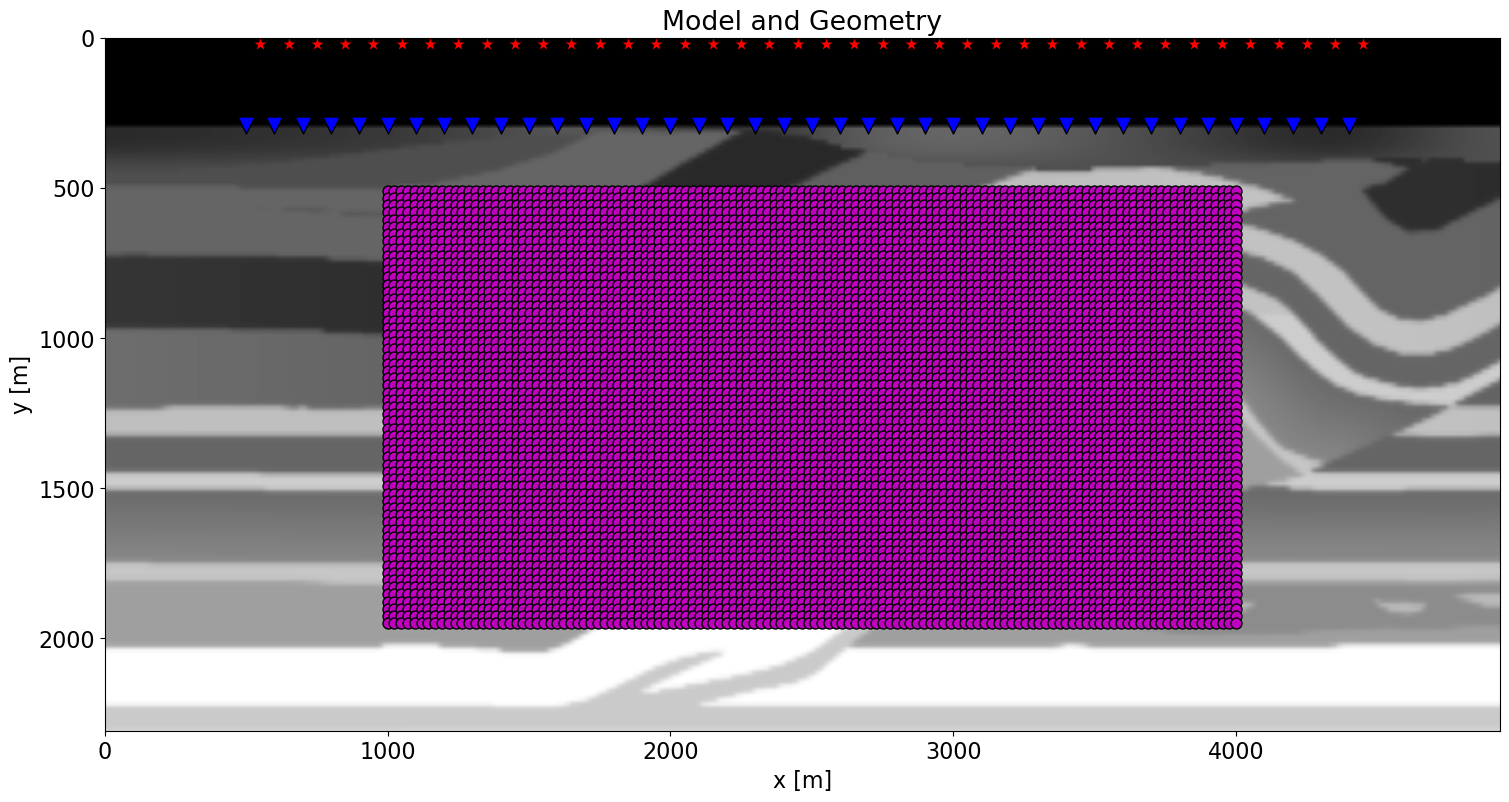

In [9]:
# Imaging domain
nvsx, nvsz = 126, 61
dvsx, dvsz = 24, 24
vsx = np.arange(nvsx)*dvsx + 1000
vsz = np.arange(nvsz)*dvsz + 510
VSX, VSZ = np.meshgrid(vsx, vsz, indexing='ij')

plt.figure(figsize=(18,9))
plt.imshow(vel, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(VSX.ravel(), VSZ.ravel(), marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

In [13]:
# para for picking positions of virtual sources (nvsx,nvsz) 
vsx_o = int((vsx[0]-x[0])/dx)
vsz_o = int((vsz[0]-z[0])/dz)
vsx_interval = int(dvsx/dx)
vsz_interval = int(dvsz/dz)
vsx_e = int(vsx[-1]/dx+1)
vsz_e = int(vsz[-1]/dz+1)

nx = x.size
nz = z.size
dx = x[1]-x[0]
dz = z[1]-z[0]

In [15]:
# vel, z ,r for computing direct arrival from vs to mirror receiver
dvel_flipud = int(np.ceil(np.max(r[1])/dz))
deltvel = np.flipud(vel[0:dvel_flipud])
vel_mr = np.vstack((deltvel, vel))

deltz = -np.flipud(z[0:dvel_flipud])-dz
z_mr = np.hstack((deltz, z))
nz_mr = z_mr.size

zr_mr = -r[1,:]
r_mr = np.vstack((r[0,:], zr_mr))

# direct arrival from vs to mirror receiver
trav_srcs_mr, trav_recs_mr, _, _, _, _ = Kirchhoff._traveltime_table(z_mr, x, s, r_mr, vel_mr.T, mode='eikonal')

trav_s_mr   = trav_srcs_mr.reshape(nx * nz_mr, ns) 
trav_s      = trav_s_mr.reshape(nx, nz_mr, ns) 
trav_s_arr  = trav_s[:,-nz:,:]

trav_r_mr   = trav_recs_mr.reshape(nx * nz_mr, nr) 
trav_mr     = trav_r_mr.reshape(nx, nz_mr, nr) 
trav_mr_arr = trav_mr[:,-nz:,:]

# para for picking virtual sources to sources and mirror receivers
trav_mr1 = trav_mr_arr[vsx_o:vsx_e,vsz_o:vsz_e,:]
trav_mr2 = trav_mr1[::vsx_interval,::vsz_interval,:]

trav_s1 = trav_s_arr[vsx_o:vsx_e,vsz_o:vsz_e,:]
trav_s2 = trav_s1[::vsx_interval,::vsz_interval,:]

vs_x = ((vs[0]-vsx[0])/dvsx).astype(int)
vs_z = ((vs[1]-vsz[0])/dvsz).astype(int)

FirstVSs = trav_s2[vs_x,vs_z,:]
FirstVSr = trav_mr2[vs_x,vs_z,:]


shape of trav_mr2: (126, 61, 400)
shape of trav_s2: (126, 61, 401)


In [16]:
# window VS-R
FirstVSr_off = FirstVSr - troff

iFirstVSr_off = np.round(FirstVSr_off/dt).astype(np.int32)
wr = np.zeros((nr, nt))

for ir in range(nr):
    wr[ir, :iFirstVSr_off[ir]]=1

wr = np.hstack((np.fliplr(wr), wr[:, 1:]))


In [17]:
# window VSS
FirstVSs_off = FirstVSs - tsoff

iFirstVSs_off = np.round(FirstVSs_off/dt).astype(np.int32)
ws = np.zeros((ns, nt))

for ir in range(ns):
    ws[ir, :iFirstVSs_off[ir]]=1
    
ws = np.hstack((np.fliplr(ws), ws[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    wr  = filtfilt(smooth, 1, wr)
    ws  = filtfilt(smooth, 1, ws)

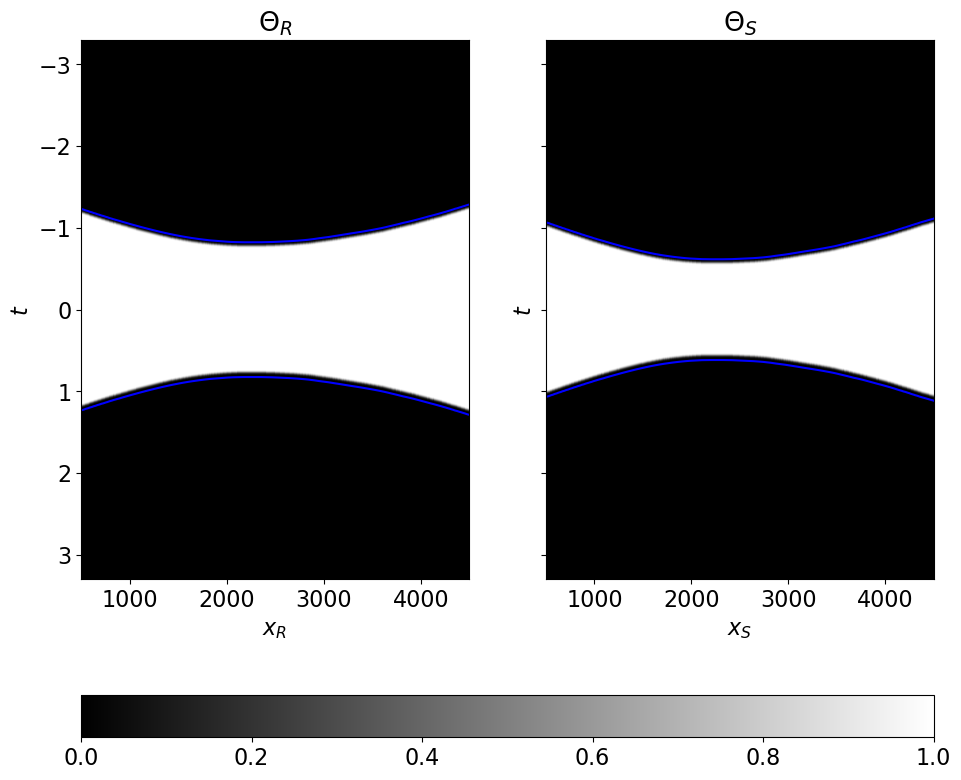

In [18]:
fig, ax = plt.subplots(1, 2,  sharey=True, figsize=(11, 10))
ax[0].imshow(wr.T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax[0].plot(r[0], FirstVSr,'b'),ax[0].plot(r[0], -FirstVSr,'b')
ax[0].set_title(r'$\Theta_R$')
ax[0].set_xlabel(r'$x_R$')
ax[0].set_ylabel(r'$t$')
ax[0].axis('tight')
im=ax[1].imshow(ws.T, cmap='gray', extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
ax[1].plot(s[0], FirstVSs,'b'),ax[1].plot(s[0], -FirstVSs,'b')
ax[1].set_title(r'$\Theta_S$')
ax[1].set_xlabel(r'$x_S$')
ax[1].set_ylabel(r'$t$')
ax[1].axis('tight')

fig.colorbar(im,ax=ax[:],orientation='horizontal');

## Inversion

In [19]:
# Add negative time to Pu operators
Putwosided = np.concatenate((np.zeros((nr, ns, nt-1)), Pu), axis=-1)         # Puw[r, s, t]
Putwosided_fft = np.fft.rfft(Putwosided, 2*nt-1, axis=-1) / np.sqrt(2*nt-1)
Putwosided_fft = Putwosided_fft[...,:nfmax]
Putwosided_fft = Putwosided_fft.transpose(2, 0, 1)                           # Puw[f, r, s]

# Operators
Puop = MDC(Putwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True)
dottest(Puop, (2*nt-1)*nr, (2*nt-1)*ns, verb=True) 

Pu1op = MDC(Putwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, conj=True)
dottest(Pu1op, (2*nt-1)*nr, (2*nt-1)*ns, verb=True)   

Dot test passed, v^H(Opu)=-149.02578791897133 - u^H(Op^Hv)=-149.0257879189715
Dot test passed, v^H(Opu)=41.16128298354973 - u^H(Op^Hv)=41.16128298354904


True

In [20]:
# Add negative time to Pd operators
Pdtwosided = np.concatenate((np.zeros((nr, ns, nt-1)), Pd), axis=-1)         # Pd[r, s, t]
Pdtwosided_fft = np.fft.rfft(Pdtwosided, 2*nt-1, axis=-1) / np.sqrt(2*nt-1)
Pdtwosided_fft = Pdtwosided_fft[...,:nfmax]
Pdtwosided_fft = Pdtwosided_fft.transpose(2, 0, 1)                           # Pd[f, r, s]

# Operators
Pdop = MDC(Pdtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True)
dottest(Pdop, (2*nt-1)*nr, (2*nt-1)*ns, verb=True)  

Pd1op = MDC(Pdtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, conj=True)
dottest(Pd1op, (2*nt-1)*nr, (2*nt-1)*ns, verb=True)    

Dot test passed, v^H(Opu)=127.3426499908816 - u^H(Op^Hv)=127.34264999088003
Dot test passed, v^H(Opu)=292.3112191601851 - u^H(Op^Hv)=292.3112191601854


True

In [21]:
# G0
G0sub_ana = directwave(wav[wav_c-wav_c:wav_c+wav_c], FirstVSs, nt, dt, nfft=2**11)
# Input focusing function
fd_plus =  np.concatenate((np.flipud(G0sub_ana), np.zeros((nt-1, ns))))

Create Marchenko operator

In [22]:
Rollop = Roll((2*nt-1) * nr,
              axis=0, shift=-1)
Wxsop = Diagonal(ws.T.flatten())
Wxrop = Diagonal(wr.T.flatten())

Dop = VStack([HStack([Wxrop*Pdop, Wxrop*Puop]),
              HStack([Wxrop*Rollop*Pu1op, Wxrop*Rollop*Pd1op])])
Mop = Dop*BlockDiag([Wxsop, Wxsop])
Gop = VStack([HStack([Pdop, Puop]),
              HStack([Rollop*Pu1op, Rollop*Pd1op])])

dottest(Gop, 2*nr*(2*nt-1), 2*ns*(2*nt-1), verb=True)
dottest(Mop, 2*nr*(2*nt-1), 2*ns*(2*nt-1), verb=True);

Dot test passed, v^H(Opu)=-130.06252699992808 - u^H(Op^Hv)=-130.06252699992905
Dot test passed, v^H(Opu)=270.1346116239672 - u^H(Op^Hv)=270.13461162396624


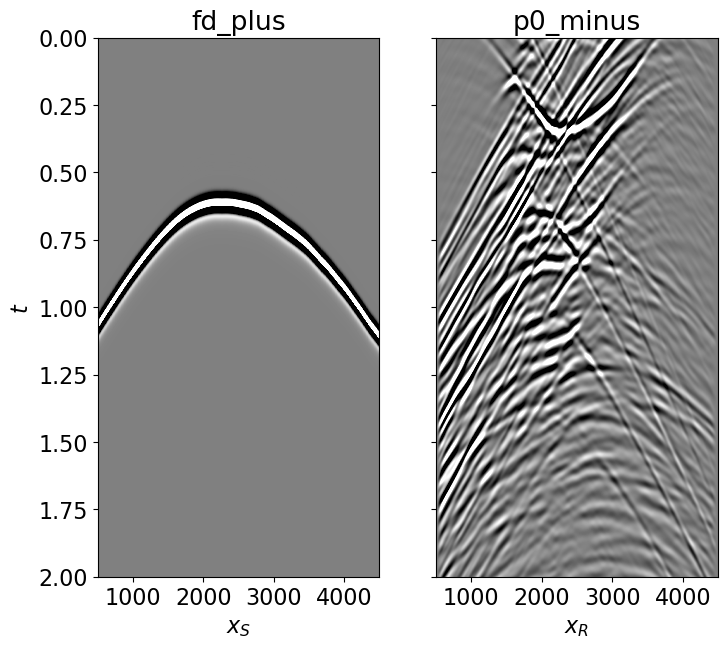

In [23]:
# Create data, adjoint and inverse focusing functions
p0_minus = Puop*fd_plus.ravel()
p0_minus = p0_minus.reshape((2*nt-1), nr).T
p0_minus_2 = np.concatenate((p0_minus, np.zeros((nr, 2*nt-1))))

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 7))
axs[0].imshow(np.flipud(fd_plus), cmap='gray', vmin=-0.1*np.abs(fd_plus).max(), 
              vmax=0.1*np.abs(fd_plus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[0].set_title('fd_plus'), axs[0].set_xlabel(r'$x_S$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0)
axs[1].imshow(p0_minus.T, cmap='gray', vmin=-0.1*np.abs(p0_minus).max(), 
              vmax=0.1*np.abs(p0_minus).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title('p0_minus'), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);

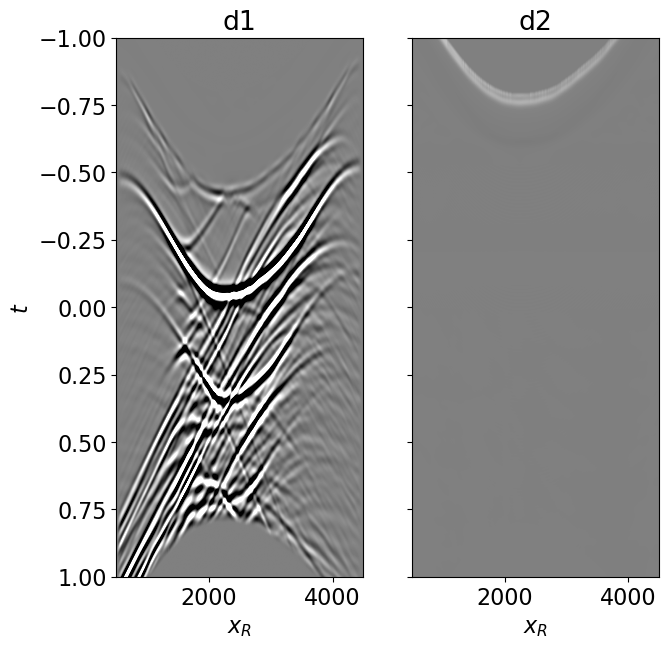

In [24]:
dinp = np.concatenate((np.zeros((2*nt-1, ns)), fd_plus), axis=0)
d = -Dop * dinp.ravel()
d = d.reshape(2*(2*nt-1), nr)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(7, 7))
axs[0].imshow(d[:(2*nt-1)], cmap='gray', vmin=-0.1*np.abs(d).max(), 
              vmax=0.1*np.abs(d).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d1'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(d[(2*nt-1):], cmap='gray', vmin=-0.1*np.abs(d).max(), 
              vmax=0.1*np.abs(d).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title('d2'), axs[1].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);

In [25]:
%%time 
f1_adj = Mop.H*d.ravel()
f1_inv = lsqr(Mop, d.ravel(), iter_lim=n_iter, show=True)[0]

f1_adj = f1_adj.reshape(2*(2*nt-1), ns)
f1_inv = f1_inv.reshape(2*(2*nt-1), ns)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 1759200 rows and 1763598 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.856e+03  1.856e+03    1.0e+00  4.6e-04
     1  0.00000e+00   1.157e+03  1.157e+03    6.2e-01  7.6e-01   1.1e+00  1.0e+00
     2  0.00000e+00   8.004e+02  8.004e+02    4.3e-01  4.2e-01   1.7e+00  2.3e+00
     3  0.00000e+00   6.402e+02  6.402e+02    3.4e-01  2.3e-01   2.2e+00  3.8e+00
     4  0.00000e+00   5.607e+02  5.607e+02    3.0e-01  1.7e-01   2.5e+00  5.2e+00
     5  0.00000e+00   5.129e+02  5.129e+02    2.8e-01  1.2e-01   2.9e+00  6.9e+00
     6  0.00000e+00   4.758e+02  4.758e+02    2.6e-01  1.2e-01   3.1e+00  8.9e+00
     7  0.00000e+00   4.349e+02  4.349e+02    2.3e-01  1.2e-01   3.4e+00  1.1e+01
     8  0.00000e+00   4.026e

Add initial guess to estimated focusing functions

In [26]:
f1_adj_tot = f1_adj + np.concatenate((np.zeros((2*nt-1, ns)),
                                      np.concatenate((np.fliplr(G0sub_ana.T).T, 
                                                      np.zeros((nt-1, ns))), axis=0)))
f1_inv_tot = f1_inv + np.concatenate((np.zeros((2*nt-1, ns)),
                                      fd_plus))

Estimate Green's functions

In [27]:
g_adj = Gop*f1_adj_tot.flatten()
g_inv = Gop*f1_inv_tot.flatten()

g_adj = g_adj.reshape(2*(2*nt-1), nr)
g_inv = g_inv.reshape(2*(2*nt-1), nr)

Extract up and down focusing and Green's functions from model vectors

In [28]:
f1_adj_minus, f1_adj_plus =  f1_adj_tot[:(2*nt-1)].T, f1_adj_tot[(2*nt-1):].T
f1_inv_minus, f1_inv_plus =  f1_inv_tot[:(2*nt-1)].T, f1_inv_tot[(2*nt-1):].T

g_adj_minus, g_adj_plus =  -g_adj[:(2*nt-1)].T, np.fliplr(g_adj[(2*nt-1):].T)
g_inv_minus, g_inv_plus =  -g_inv[:(2*nt-1)].T, np.fliplr(g_inv[(2*nt-1):].T)

g_inv_tot = g_inv_minus + g_inv_plus

Visualization

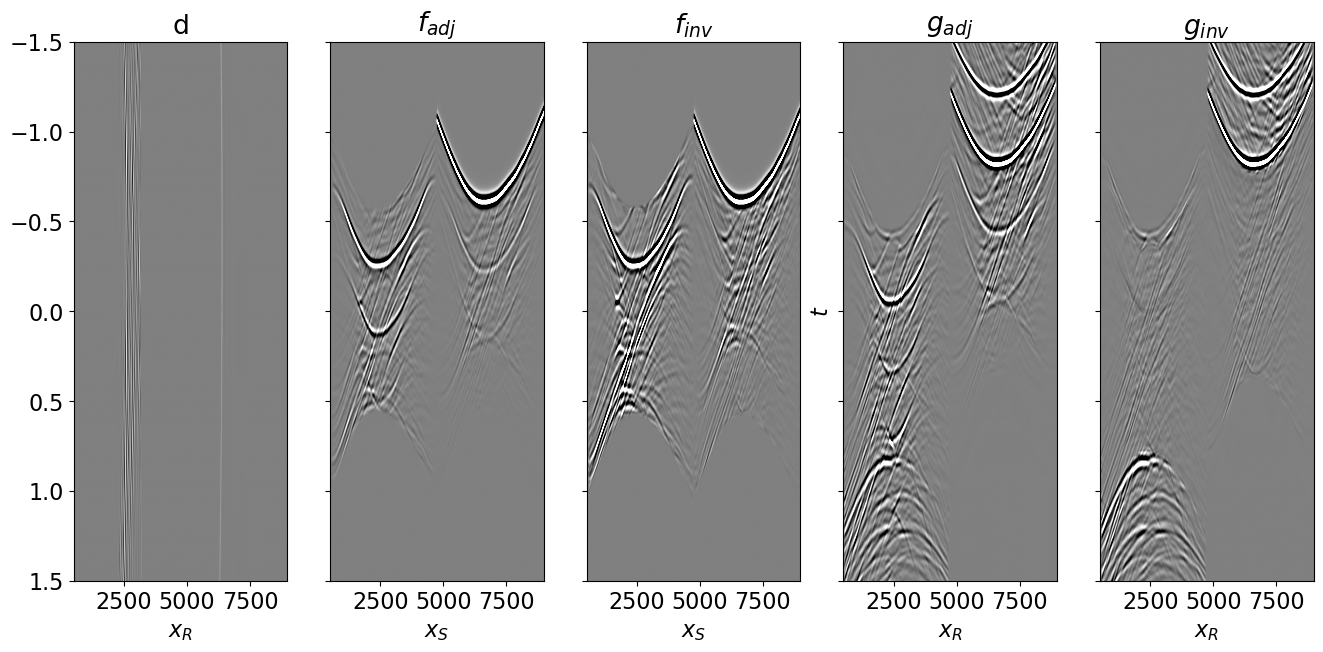

In [29]:
f1_adj_tot = np.concatenate((f1_adj_tot[:(2*nt-1)], f1_adj_tot[(2*nt-1):]), axis=1).T
f1_inv_tot = np.concatenate((f1_inv_tot[:(2*nt-1)], f1_inv_tot[(2*nt-1):]), axis=1).T
g_adj = np.concatenate((g_adj[:(2*nt-1)], g_adj[(2*nt-1):]), axis=1).T
g_inv = np.concatenate((g_inv[:(2*nt-1)], g_inv[(2*nt-1):]), axis=1).T

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(d.T, cmap='gray', vmin=-0.1*np.abs(d).max(), 
              vmax=0.1*np.abs(d).max(), extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_R$'), axs[3].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(f1_adj_tot.T, cmap='gray', vmin=-0.1*np.abs(f1_adj_tot).max(), 
              vmax=0.1*np.abs(f1_adj_tot).max(), extent=(s[0,0], 2*s[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{adj}$'), axs[1].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[2].imshow(f1_inv_tot.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_tot).max(), 
              vmax=0.1*np.abs(f1_inv_tot).max(), extent=(s[0,0], 2*s[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv}$'), axs[2].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[3].imshow(g_adj.T, cmap='gray', vmin=-0.1*np.abs(g_adj).max(), 
              vmax=0.1*np.abs(g_adj).max(), extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{adj}$'), axs[3].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[4].imshow(g_inv.T, cmap='gray', vmin=-0.1*np.abs(g_inv).max(), 
              vmax=0.1*np.abs(g_inv).max(), extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv}$'), axs[4].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(1.5, -1.5);

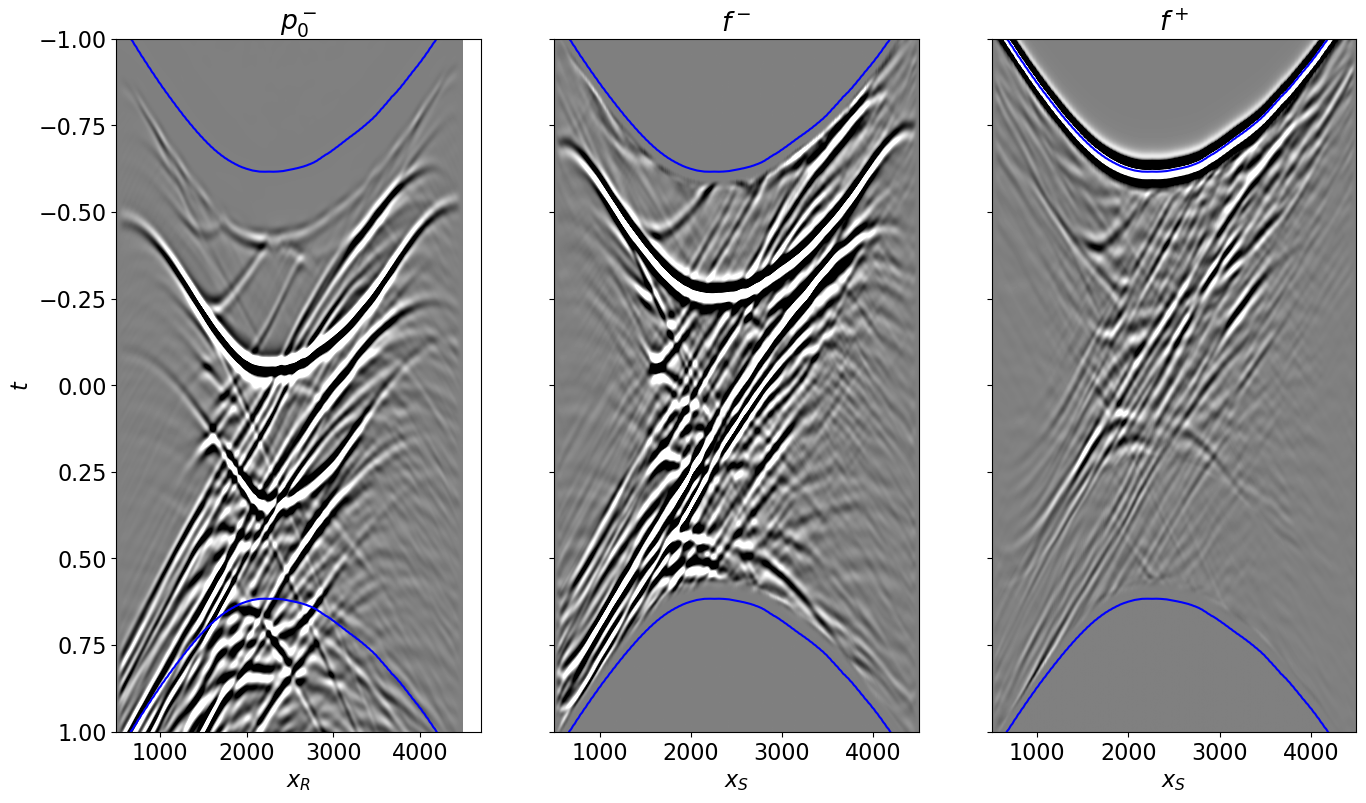

In [30]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-0.1*np.abs(p0_minus).max(), 
              vmax=0.1*np.abs(p0_minus).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].plot(s[0], FirstVSs,'b'),axs[0].plot(s[0], -FirstVSs,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_minus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_minus).max(), 
              vmax=0.1*np.abs(f1_inv_minus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[1].set_xlabel(r'$x_S$')
axs[1].plot(s[0], FirstVSs,'b'),axs[1].plot(s[0], -FirstVSs,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_plus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_plus).max(), 
              vmax=0.1*np.abs(f1_inv_plus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[2].set_xlabel(r'$x_S$')
axs[2].plot(s[0], FirstVSs,'b'),axs[2].plot(s[0], -FirstVSs,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

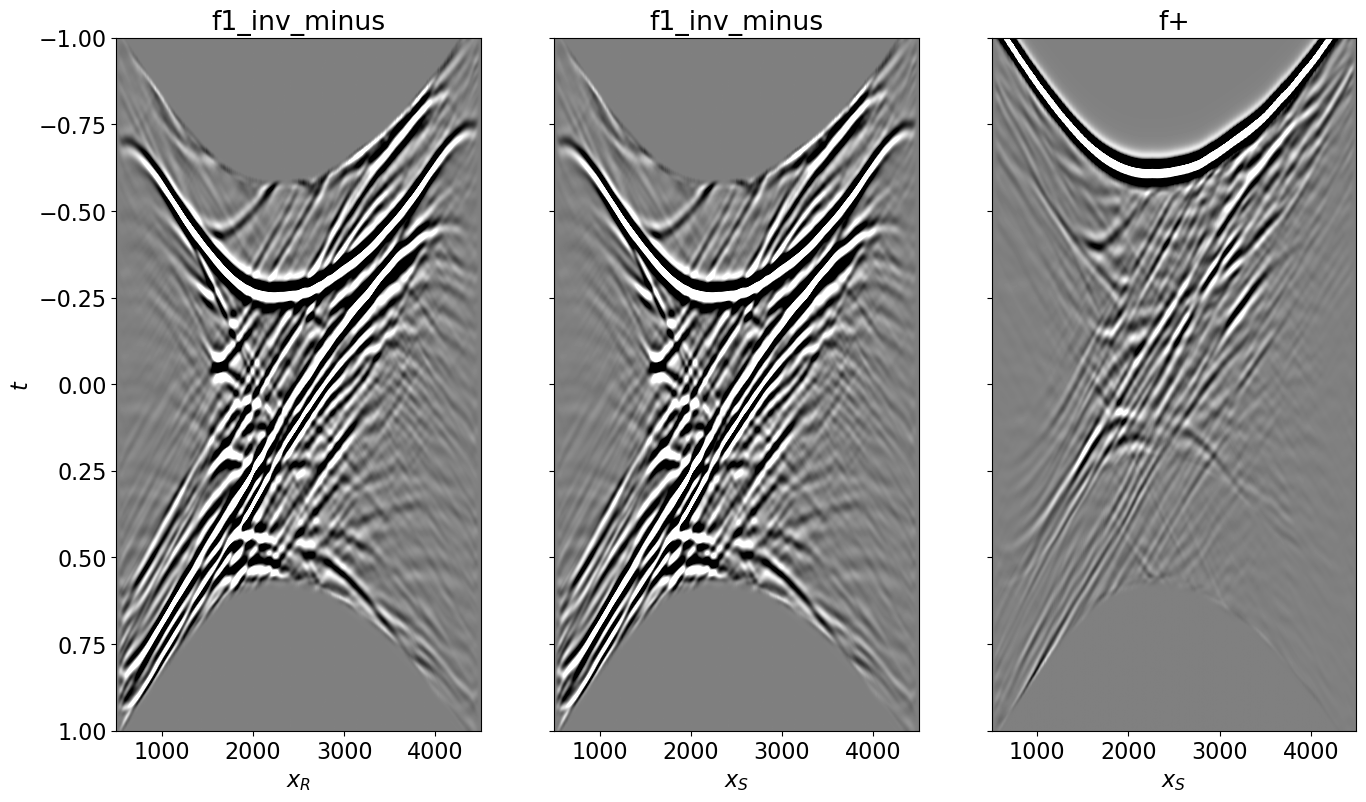

In [31]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(f1_inv_minus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_minus).max(), 
              vmax=0.1*np.abs(f1_inv_minus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[0].set_title('f1_inv_minus'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
# axs[0].plot(s[0], FirstVSs,'b'),axs[0].plot(s[0], -FirstVSs,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_minus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_minus).max(), 
              vmax=0.1*np.abs(f1_inv_minus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[1].set_title('f1_inv_minus'), axs[1].set_xlabel(r'$x_S$')
# axs[1].plot(s[0], FirstVSs,'b'),axs[1].plot(s[0], -FirstVSs,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_plus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_plus).max(), 
              vmax=0.1*np.abs(f1_inv_plus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[2].set_title('f+'), axs[2].set_xlabel(r'$x_S$')
# axs[2].plot(s[0], FirstVSs,'b'),axs[2].plot(s[0], -FirstVSs,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

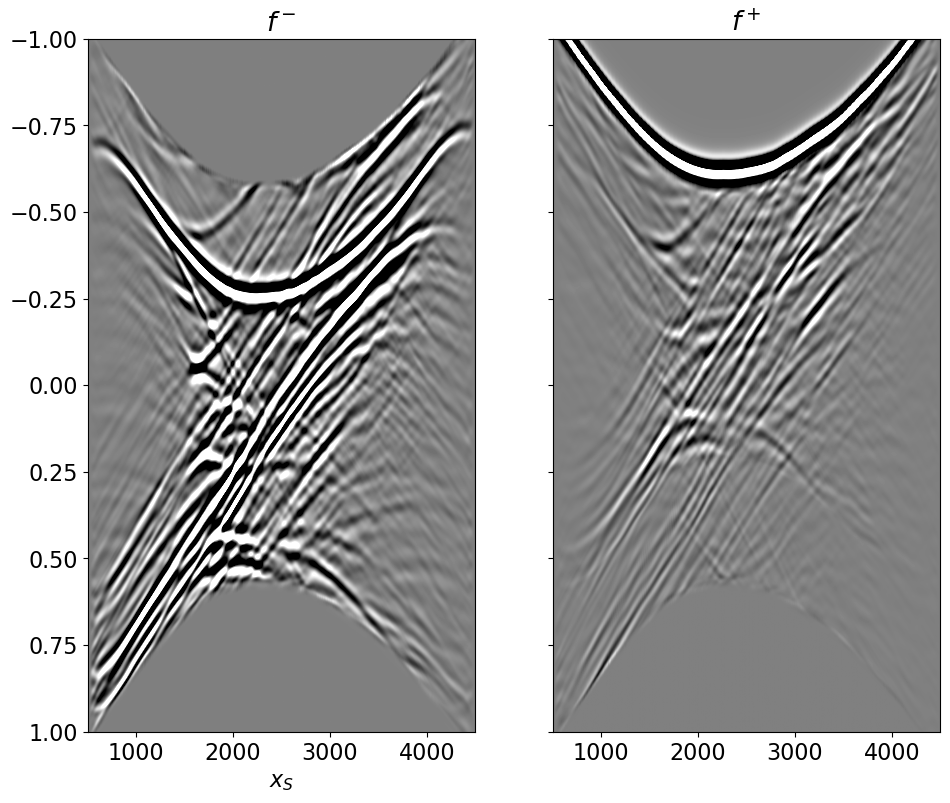

In [32]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(11, 9))
axs[0].imshow(f1_inv_minus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_minus).max(), 
              vmax=0.1*np.abs(f1_inv_minus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_S$')
# axs[0].plot(r[0], FirstVSs,'b'),axs[0].plot(r[0], -FirstVSs,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_plus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_plus).max(), 
              vmax=0.1*np.abs(f1_inv_plus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_S$')
# axs[1].plot(r[0], FirstVSs,'b'),axs[1].plot(r[0], -FirstVSs,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);

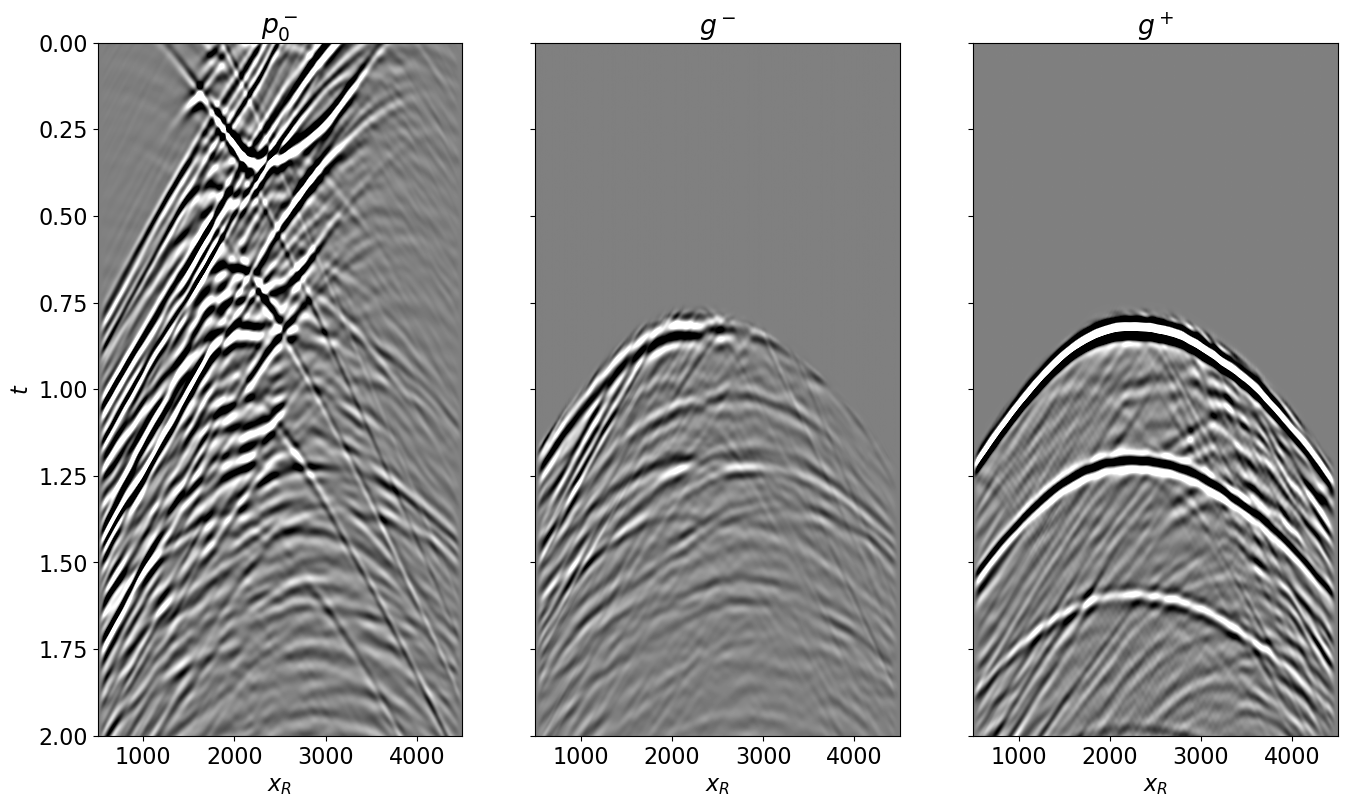

In [33]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-0.1*np.abs(p0_minus).max(), 
              vmax=0.1*np.abs(p0_minus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow((1-wr.T) * g_inv_minus.T, cmap='gray', vmin=-0.1*np.abs(g_inv_plus+g_inv_minus).max(), 
              vmax= 0.1*np.abs(g_inv_plus+g_inv_minus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow((1-wr.T) * g_inv_plus.T, cmap='gray', vmin=-0.1*np.abs(g_inv_plus+g_inv_minus).max(), 
              vmax=0.1*np.abs(g_inv_plus+g_inv_minus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

In [44]:
inputfile = '/home/wangn0e/2022-2023/first_research/upside_down_RM_1version/overthrustRM15_x2200z1206.npy' 
g_true = np.load(inputfile)

g_true = dt * np.apply_along_axis(convolve, -1, g_true, wav, mode='full')
g_true = g_true[..., wav_c:][..., :nt]
g_true = g_true[0,:-1]
g_true = -(1-wr[:, nt-1:]) *g_true/g_true.max()

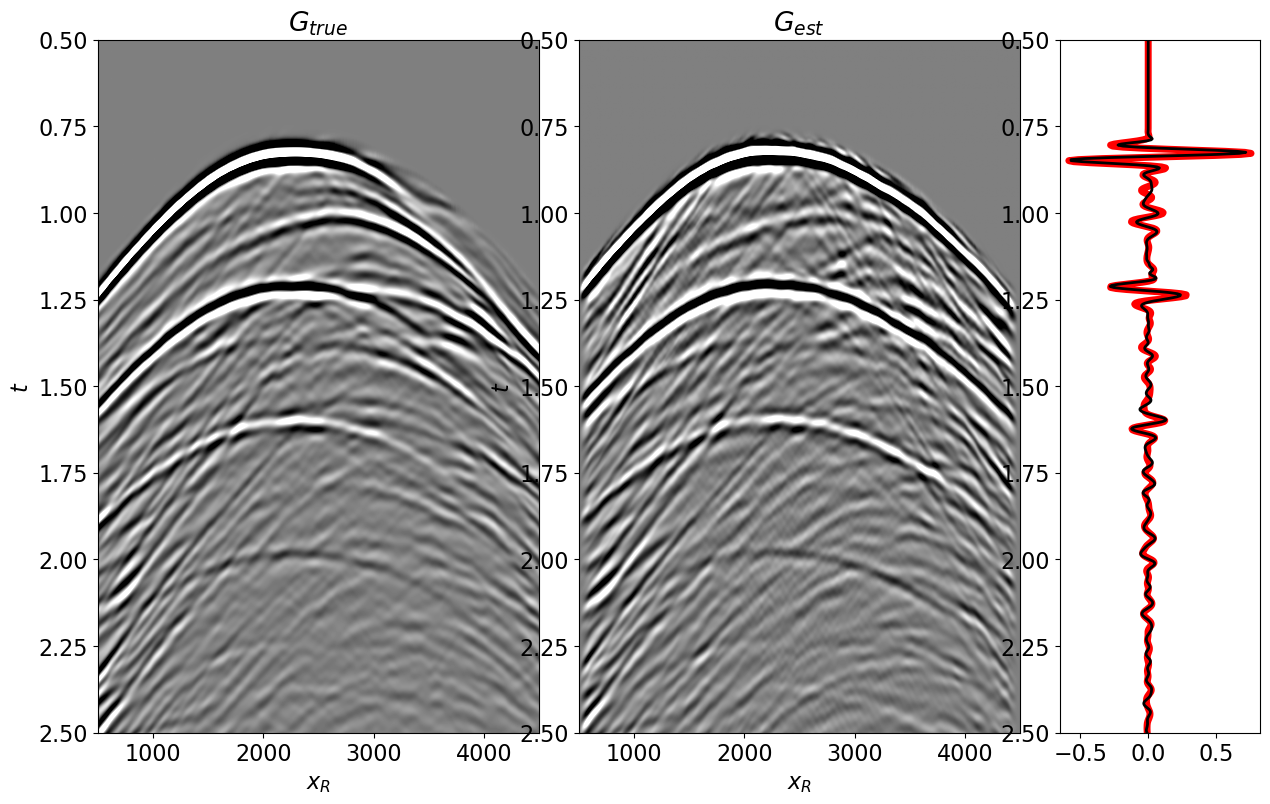

In [45]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

g_inv_tot_norm = (1-wr[:, nt-1:]) * (g_inv_tot[:, nt-1:])/(g_inv_tot).max()

ax1.imshow(g_true.T, cmap='gray', vmin=-0.1*np.abs(g_true).max(), 
           vmax=0.1*np.abs(g_true).max(), extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(2.5, 0.5)
ax2.imshow(g_inv_tot_norm.T, cmap='gray', vmin=-0.1*np.abs(g_inv_tot_norm).max(), 
           vmax=0.1*np.abs(g_inv_tot_norm).max(), extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(2.5, 0.5)

ax3.plot((g_true[ns//2,:])/(g_true).max(), t, 'r', lw=5)
ax3.plot((g_inv_tot_norm[ns//2, :])/(g_inv_tot_norm).max(), t, 'k', lw=2)
ax3.set_ylim(2.5, 0.5);